In [1]:
import os
import re
import sys
import json
import unicodedata
import numpy as np
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
from pymongo import MongoClient

client = MongoClient('192.168.0.209', 27017)
db = client['reverb']
sales_coll = db['sales']
data_coll = db['data']


In [2]:
data_df = pd.DataFrame(list(data_coll.find({},{'_id':0})))
sales_df = pd.DataFrame(list(sales_coll.find({},{'_id':0})))

In [3]:
print(data_df.info())
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     2990 non-null   object 
 1   brand     2990 non-null   object 
 2   model     2990 non-null   object 
 3   year      2990 non-null   object 
 4   color     2979 non-null   object 
 5   est_low   2990 non-null   float64
 6   est_high  2990 non-null   float64
 7   text      2823 non-null   object 
dtypes: float64(2), object(6)
memory usage: 187.0+ KB
None


,title,brand,model,year,color,est_low,est_high,text
0,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this..."
1,Fender Coronado II 1968 Antigua,Fender,Coronado II,1968,Antigua,1450.0,2235.0,Designed by Roger Rossmeisl who came onto Fend...
2,Fender Stratocaster 1958 Sunburst,Fender,Stratocaster,1958,Sunburst,15635.0,20220.0,Building on the success of the first few years...
3,Fender Stratocaster 1964 Sunburst,Fender,Stratocaster,1964,Sunburst,9800.0,18335.0,"For many collectors, 1964 was an absolute peak..."
4,Epiphone Zephyr 1944 Sunburst,Epiphone,Zephyr,1944,Sunburst,1100.0,1600.0,The Zephyr was an early electric archtop desig...


In [4]:
print(sales_df.info())
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145380 entries, 0 to 145379
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   145380 non-null  object 
 1   date    145380 non-null  object 
 2   cond    145380 non-null  object 
 3   price   145380 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.4+ MB
None


,title,date,cond,price
0,Rickenbacker 660-12 Tom Petty Signature 1992,2/23/2021,Excellent,6495.0
1,Rickenbacker 660-12 Tom Petty Signature 1992,12/7/2020,Excellent,4325.0
2,Rickenbacker 660-12 Tom Petty Signature 1992,10/20/2020,Excellent,7995.0
3,Rickenbacker 660-12 Tom Petty Signature 1992,9/28/2020,Excellent,5495.0
4,Rickenbacker 660-12 Tom Petty Signature 1992,5/26/2020,Excellent,5800.0


In [5]:
sales = sales_df.groupby('title').mean().round(2)
records = sales_df.value_counts('title').to_frame()
data_df = data_df.merge(sales.rename(columns={'price': 'mean_sale'}), on='title')
data_df = data_df.merge(records.rename(columns={0: 'num_records'}), on='title')
data_df.head()

,title,brand,model,year,color,est_low,est_high,text,mean_sale,num_records
0,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54
1,Fender Coronado II 1968 Antigua,Fender,Coronado II,1968,Antigua,1450.0,2235.0,Designed by Roger Rossmeisl who came onto Fend...,2096.55,56
2,Fender Stratocaster 1958 Sunburst,Fender,Stratocaster,1958,Sunburst,15635.0,20220.0,Building on the success of the first few years...,19348.32,16
3,Fender Stratocaster 1964 Sunburst,Fender,Stratocaster,1964,Sunburst,9800.0,18335.0,"For many collectors, 1964 was an absolute peak...",12714.49,59
4,Epiphone Zephyr 1944 Sunburst,Epiphone,Zephyr,1944,Sunburst,1100.0,1600.0,The Zephyr was an early electric archtop desig...,1103.12,8


In [6]:
int_years = pd.Series([int(year) for year in data_df['year'] if year.isdigit()])

# For years that include 'early', 'mid' or 'late' we'll choose a year at random
eml_dict = {
    'early': (0, 4),
    'mid': (4, 7),
    'late': (7, 10)
}

def year_to_int(year):
    # If the year is already a digit, we're done
    if year.isdigit():
        return int(year)
    
    # Check for "early"/"mid"/"late" and build year integer accordingly
    # "Early 70s" becomes a random year between 1970 and 1973 
    for eml, nums in eml_dict.items():
        if eml in year:
            year = year.strip('s').replace("'", '').replace('-', ' ').split()[1]
            year = int('19' + year if len(year) < 4 else year)
            year += np.random.randint(*eml_dict[eml])
            return year
    
    if '-' in year: # Here we find date ranges such as "1938-1943"
        splt = year.split('-')
        low = int(splt[0])
        high = int(splt[1])
        # We have a couple strange instances here where a model #
        
    else:  # Here we find 2-digit year strings such as "60s"
        # Add 19 if only decade is included
        base = '19' + year if len(year) < 4 else year
        # Remove apostrophes and pluralisations
        base = base.replace("'", '').strip('s')
        low = int(base)
        high = low + 9
    
    # Find average year of all guitars from date range already stored
    avg = round(int_years[(int_years >= low) & (int_years <= high)].mean())
    return avg
    print(year)


In [7]:
data_df['year_str'] = data_df['year']
data_df['year'] = data_df['year'].apply(year_to_int)

In [8]:
merge_df = data_df.merge(sales_df, on='title')
merge_df

,title,brand,model,year,color,est_low,est_high,text,mean_sale,num_records,year_str,date,cond,price
0,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,2/23/2021,Excellent,6495.0
1,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,12/7/2020,Excellent,4325.0
2,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,10/20/2020,Excellent,7995.0
3,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,9/28/2020,Excellent,5495.0
4,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,5/26/2020,Excellent,5800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145345,Rickenbacker Silver Hawaiian Model NS 100 Lap ...,Rickenbacker,Silver Hawaiian Model NS 100 Lap Steel,1940,Nickel,760.0,1095.0,None,906.47,16,1938 - 1943,1/18/2018,Very Good,999.0
145346,Rickenbacker Silver Hawaiian Model NS 100 Lap ...,Rickenbacker,Silver Hawaiian Model NS 100 Lap Steel,1940,Nickel,760.0,1095.0,None,906.47,16,1938 - 1943,12/12/2017,Good,349.0
145347,Rickenbacker Silver Hawaiian Model NS 100 Lap ...,Rickenbacker,Silver Hawaiian Model NS 100 Lap Steel,1940,Nickel,760.0,1095.0,None,906.47,16,1938 - 1943,12/6/2017,Excellent,925.0
145348,Rickenbacker Silver Hawaiian Model NS 100 Lap ...,Rickenbacker,Silver Hawaiian Model NS 100 Lap Steel,1940,Nickel,760.0,1095.0,None,906.47,16,1938 - 1943,8/2/2017,Very Good,925.0


Text(0.5, 1.0, 'Sales Records per Brand')

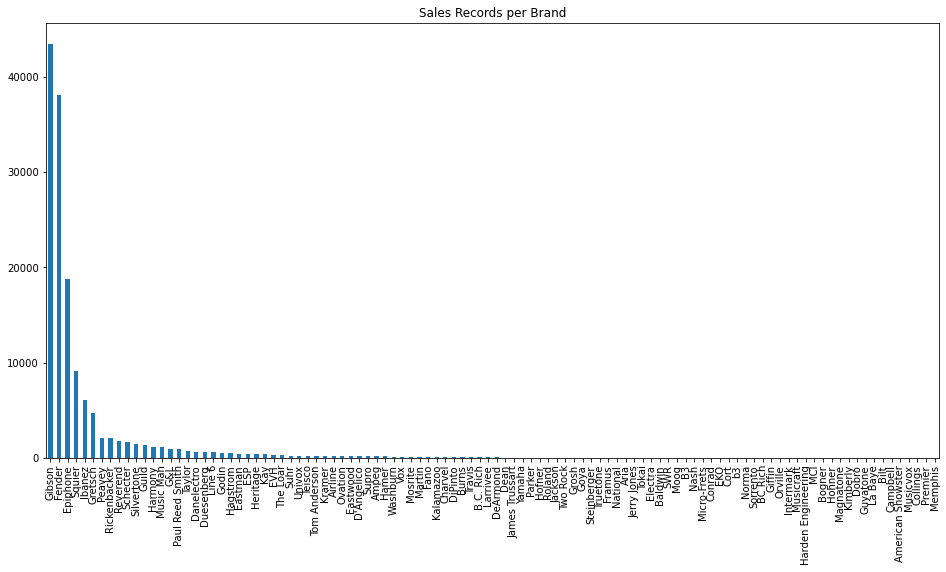

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
merge_df['brand'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Sales Records per Brand')

Text(0.5, 1.0, 'Mean Sale Amt by Brand')

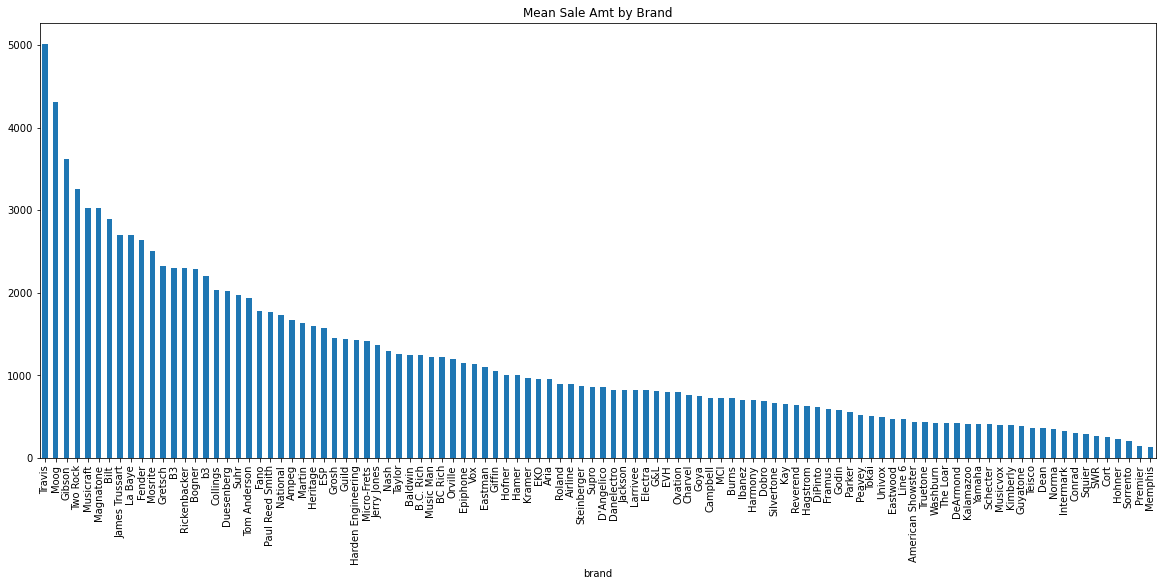

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
mean_sales_by_brand = data_df.groupby('brand')['mean_sale'].mean().sort_values(ascending=False)
mean_sales_by_brand.plot(x='brand', y='mean_sale', kind='bar', ax=ax)
ax.set_title('Mean Sale Amt by Brand')

Text(0.5, 1.0, 'Max Sale Amt by Brand')

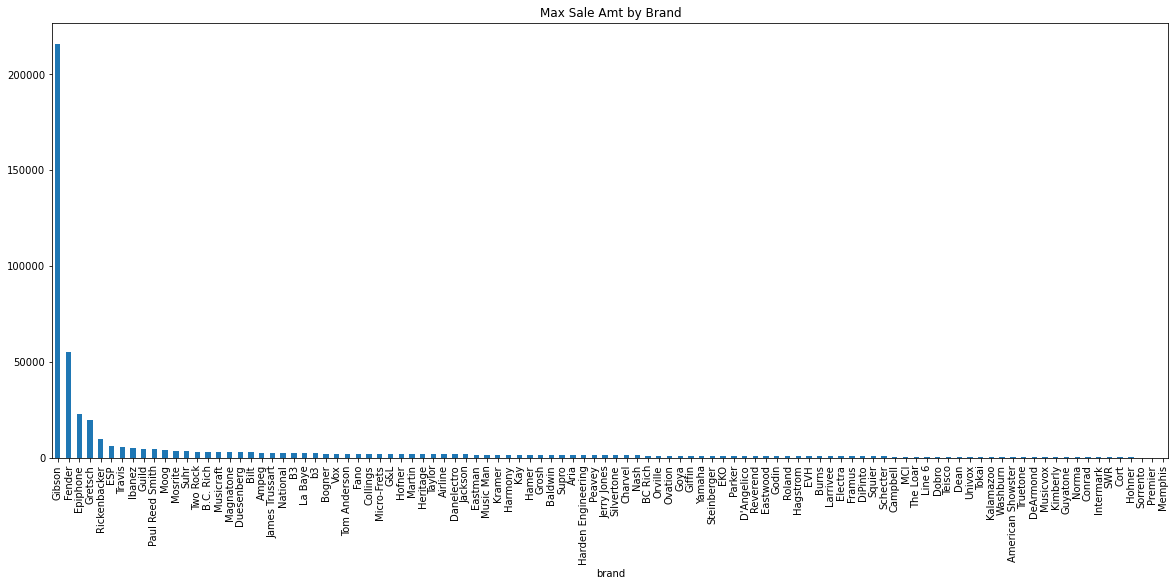

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
mean_sales_by_brand = data_df.groupby('brand')['mean_sale'].max().sort_values(ascending=False)
mean_sales_by_brand.plot(x='brand', y='mean_sale', kind='bar', ax=ax)
ax.set_title('Max Sale Amt by Brand')

Text(0.5, 1.0, 'Guitar Models by Year')

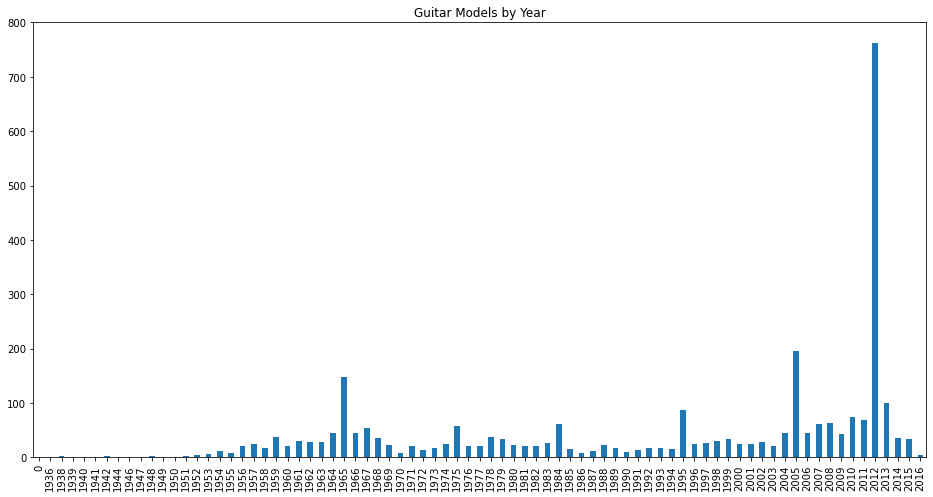

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
data_df['year'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Guitar Models by Year')

In [13]:
data_df[(data_df['year'] == 2012)]# & (data_df['year_str'] == '2012')]

,title,brand,model,year,color,est_low,est_high,text,mean_sale,num_records,year_str
25,Epiphone Ace Frehley Budokan Les Paul Custom O...,Epiphone,Ace Frehley Budokan Les Paul Custom Outfit,2012,Cherry Sunburst,870.0,1255.0,Modeled after the Les Paul Kiss' Ace Frehley p...,943.56,105,2012
44,Epiphone Dot 2010s Ebony,Epiphone,Dot,2012,Ebony,310.0,480.0,The Epiphone Dot sits on the lower end of Epip...,325.32,128,2010s
45,Epiphone Dot 2010s Cherry,Epiphone,Dot,2012,Cherry,295.0,400.0,The Epiphone Dot sits on the lower end of Epip...,324.04,267,2010s
47,Epiphone Elitist Dwight Trash Casino Outfit 20...,Epiphone,Elitist Dwight Trash Casino Outfit,2012,White,1700.0,2000.0,Years of Production: |2012,2500.91,2,2012
48,Epiphone Emperor Regent 2012 Natural,Epiphone,Emperor Regent,2012,Natural,425.0,755.0,Body Style: |Archtop|Wood Composition: |Maple ...,584.31,19,2012
...,...,...,...,...,...,...,...,...,...,...,...
2972,Fender GE Smith Telecaster 2010s Black,Fender,GE Smith Telecaster,2012,Black,1300.0,1800.0,The GE Smith Signature Telecaster was designed...,1912.50,4,2010s
2973,Fender GE Smith Telecaster 2010s Honey Blonde,Fender,GE Smith Telecaster,2012,Honey Blonde,1610.0,1935.0,The GE Smith Signature Telecaster was designed...,1658.51,38,2010s
2974,Paul Reed Smith P22 2010s Flame Top,Paul Reed Smith,P22,2012,Flame Top,2175.0,2825.0,The P22 offers the same features of PRS' flags...,2354.92,42,2010s
2982,"Rickenbacker 330/12 2010s Mapleglo, Fireglo or...",Rickenbacker,330/12,2012,"Mapleglo, Fireglo or Jetglo",1660.0,1985.0,"One of Rickenbacker's most popular models, the...",1610.97,56,2010s
